In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import cv2
import random
import math
import re
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn.visualize import display_instances
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config
from mrcnn import model as modellib, utils

#import custom

# Root directory of the project
ROOT_DIR = "D:\\UTM\\SEM 8\\FYP 2\\Rockmelon"

DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

MODEL_DIR = os.path.join(ROOT_DIR, "logs")


WEIGHTS_PATH = "D:\\UTM\\SEM 8\\FYP 2\\Rockmelon\\logs\\object20220625T1158\\mask_rcnn_object_0040.h5"   # change it

In [2]:
class CustomConfig(Config):
    """Configuration for training on the custom  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "object"

    IMAGES_PER_GPU = 1

    NUM_CLASSES = 1 + 2  # Background + Downey Mildew, Powdery Mildew

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 10

    # Skip detections with < 60% confidence
    DETECTION_MIN_CONFIDENCE = 0.60

In [3]:
config = CustomConfig()
CUSTOM_DIR = os.path.join(ROOT_DIR, "/dataset_real/")
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.60

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.6
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.0001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE        

In [4]:
# Code for Custom dataset class. Same code is present in custom.py file also
class CustomDataset(utils.Dataset):

	def load_custom(self, dataset_dir, subset):

		self.add_class("object", 1, "Downey_Mildew")
		self.add_class("object", 2, "Powdery_Mildew")

		assert subset in ["train", "test_val"]
		dataset_dir = os.path.join(dataset_dir, subset)
		#annotations1 = json.load(open('D:/MaskRCNN-aar/Dataset/train/demo_json.json'))
		annotations1 = json.load(open(os.path.join(dataset_dir, 'demo_json.json')))

		annotations = list(annotations1.values())  # don't need the dict keys

		annotations = [a for a in annotations if a['regions']]
		
		# Add images
		for a in annotations:
		   
			polygons = [r['shape_attributes'] for r in a['regions']] 
			objects = [s['region_attributes']['names'] for s in a['regions']]
			print("objects:",objects)
			name_dict = {"Downey_Mildew": 1,"Powdery_Mildew": 2}
			num_ids = [name_dict[a] for a in objects]

			print("numids",num_ids)
			image_path = os.path.join(dataset_dir, a['filename'])
			image = skimage.io.imread(image_path)
			height, width = image.shape[:2]

			self.add_image(
				"object", 
				image_id=a['filename'],  # use file name as a unique image id
				path=image_path,
				width=width, height=height,
				polygons=polygons,
				num_ids=num_ids
				)

	def load_mask(self, image_id):
	   
		image_info = self.image_info[image_id]
		if image_info["source"] != "object":
			return super(self.__class__, self).load_mask(image_id)

		info = self.image_info[image_id]
		if info["source"] != "object":
			return super(self.__class__, self).load_mask(image_id)
		num_ids = info['num_ids']
		mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
						dtype=np.uint8)
		for i, p in enumerate(info["polygons"]):

			rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])

			mask[rr, cc, i] = 1

		num_ids = np.array(num_ids, dtype=np.int32)
		return mask, num_ids #np.ones([mask.shape[-1]], dtype=np.int32)

	def image_reference(self, image_id):
		"""Return the path of the image."""
		info = self.image_info[image_id]
		if info["source"] == "object":
			return info["path"]
		else:
			super(self.__class__, self).image_reference(image_id)

In [5]:
# Inspect the model in training or inference modes values: 'inference' or 'training'
TEST_MODE = "inference"
ROOT_DIR = "D:\\UTM\\SEM 8\\FYP 2\\Rockmelon\\datasets_real"

def get_ax(rows=1, cols=1, size=16):
  """Return a Matplotlib Axes array to be used in all visualizations in the notebook.  Provide a central point to control graph sizes. Adjust the size attribute to control how big to render images"""
  _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
  return ax

# Load validation dataset
# Must call before using the dataset
CUSTOM_DIR = "D:\\UTM\\SEM 8\\FYP 2\\Rockmelon\\datasets_real"
dataset = CustomDataset()
dataset.load_custom(CUSTOM_DIR, "test_val")
dataset.prepare()
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

objects: ['Downey_Mildew', 'Downey_Mildew', 'Downey_Mildew', 'Downey_Mildew', 'Downey_Mildew', 'Downey_Mildew', 'Downey_Mildew', 'Downey_Mildew', 'Downey_Mildew', 'Downey_Mildew', 'Downey_Mildew', 'Downey_Mildew', 'Downey_Mildew', 'Downey_Mildew', 'Downey_Mildew', 'Downey_Mildew', 'Downey_Mildew', 'Downey_Mildew', 'Downey_Mildew', 'Downey_Mildew', 'Downey_Mildew', 'Downey_Mildew', 'Downey_Mildew', 'Downey_Mildew', 'Downey_Mildew', 'Downey_Mildew', 'Downey_Mildew', 'Downey_Mildew', 'Downey_Mildew', 'Downey_Mildew', 'Downey_Mildew', 'Downey_Mildew', 'Downey_Mildew', 'Downey_Mildew', 'Downey_Mildew', 'Downey_Mildew', 'Downey_Mildew', 'Downey_Mildew', 'Downey_Mildew', 'Downey_Mildew', 'Downey_Mildew', 'Downey_Mildew', 'Downey_Mildew', 'Downey_Mildew', 'Downey_Mildew', 'Downey_Mildew', 'Downey_Mildew', 'Downey_Mildew', 'Downey_Mildew', 'Downey_Mildew', 'Downey_Mildew', 'Downey_Mildew', 'Downey_Mildew', 'Downey_Mildew', 'Downey_Mildew', 'Downey_Mildew', 'Downey_Mildew', 'Downey_Mildew', 'Dow

In [6]:
config = CustomConfig()
#LOAD MODEL. Create model in inference mode
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

Instructions for updating:
Use fn_output_signature instead


In [7]:
# Load COCO weights Or, load the last model you trained
weights_path = WEIGHTS_PATH
# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  D:\UTM\SEM 8\FYP 2\Rockmelon\logs\object20220625T1158\mask_rcnn_object_0040.h5
Re-starting from epoch 40


In [8]:
#Now, we are ready for testing our model on any image.

#RUN DETECTION
image_id = random.choice(dataset.image_ids)
#image_id = 'D:/MaskRCNN-aar/Dataset/val/1.jfif'
print("image id is :",image_id)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
modellib.load_image_gt(dataset, config, image_id) #, use_mini_mask=False
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id,dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

image id is : 5
image ID: object.048.jpg (5) D:\UTM\SEM 8\FYP 2\Rockmelon\datasets_real\test_val\048.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  252.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  135.20000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


## Prediction on Single Image
T1/T2/T3/T4/T5/T6/T7/T8/T9/T10/T11/T12/T13/T14/T15/T16/T17/T18/T19/T20/T21/T22/T23/T24/T25/T26/T27/T28/T29

1
Processing 1 images
image                    shape: (489, 770, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  137.20000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


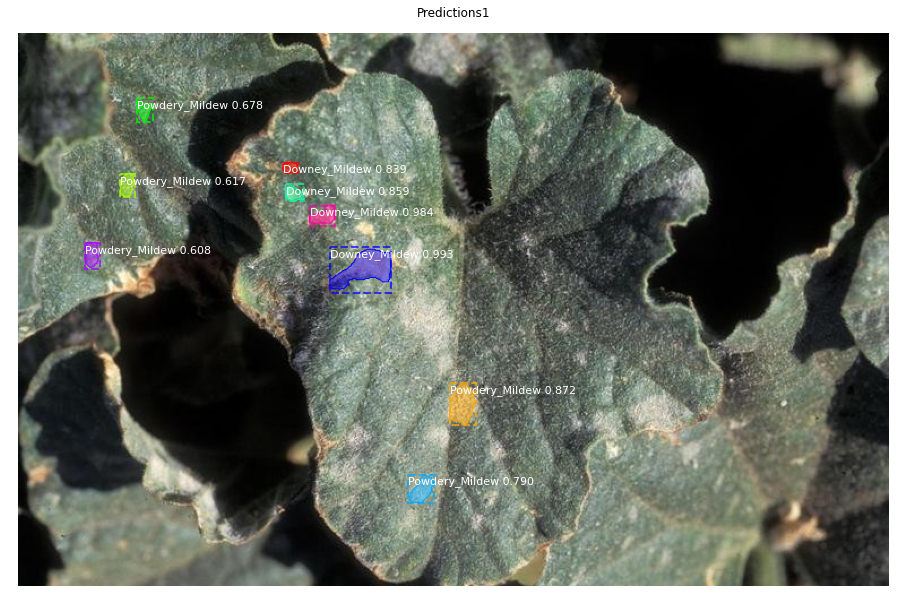

In [22]:
path_to_new_image = 'D:\\UTM\\SEM 8\\FYP 2\\Rockmelon\\dataset\\test\\T5.jpg'
image1 = mpimg.imread(path_to_new_image)

# Run object detection
print(len([image1]))
results1 = model.detect([image1], verbose=1)


# Display results
ax = get_ax(1)
r1 = results1[0]
visualize.display_instances(image1, r1['rois'], r1['masks'], r1['class_ids'],
dataset.class_names, r1['scores'], ax=ax, title="Predictions1")

## Mean average precision

In [10]:
#import utils


total_gt = np.array([]) 
total_pred = np.array([]) 
mAP_ = [] #mAP list

#compute total_gt, total_pred and mAP for each image in the test dataset
# Compute total ground truth boxes(total_gt) and total predicted boxes(total_pred) and mean average precision for each Image 
#in the test dataset
for image_id in dataset.image_ids:
    image, image_meta, gt_class_id, gt_bbox, gt_mask =modellib.load_image_gt(dataset, config, image_id)#, #use_mini_mask=False)
    info = dataset.image_info[image_id]

    # Run the model
    results = model.detect([image], verbose=1)
    r = results[0]
    
    #compute gt_tot and pred_tot
    gt, pred = utils.gt_pred_lists(gt_class_id, gt_bbox, r['class_ids'], r['rois'])
    total_gt = np.append(total_gt, gt)
    total_pred = np.append(total_pred, pred)
    
    #precision_, recall_, AP_ 
    AP_, precision_, recall_, overlap_ = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
    #check if the vectors len are equal
    print("the actual length of the ground truth vect is : ", len(total_gt))
    print("the actual length of the predicted vect is : ", len(total_pred))
    
    mAP_.append(AP_)
    print("Average precision of this image : ",AP_)
    print("The actual mean average precision for the whole images", sum(mAP_)/len(mAP_))

import pandas as pd
total_gt=total_gt.astype(int)
total_pred=total_pred.astype(int)
#save the vectors of gt and pred
save_dir = "output"
gt_pred_tot_json = {"Total Groundtruth" : total_gt, "predicted box" : total_pred}
df = pd.DataFrame(gt_pred_tot_json)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
df.to_json(os.path.join(save_dir,"gt_pred_test.json"))

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  253.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  136.20000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


ValueError: shapes (68,1048576) and (3136,82) not aligned: 1048576 (dim 1) != 3136 (dim 0)

## Confusion matrix

In [ ]:
tp,fp,fn=utils.plot_confusion_matrix_from_data(total_gt,total_pred,fz=18, figsize=(20,20), lw=0.5)
#The vertical axis represent the ground-truth classes and the horizontal axis represent the predicted classes.
#BG class is the background class.
# It is not taken into account in the calculation of the mAP.

In [ ]:
print("tp for each class :",tp)
print("fp for each class :",fp)
print("fn for each class :",fn)

#eliminate the background class (class A) from tps fns and fns lists since it doesn't concern us anymore : 
del tp[0]
del fp[0]
del fn[0]
print("\n########################\n")
print("tp for each class :",tp)
print("fp for each class :",fp)
print("fn for each class :",fn)